# LAB 2 MOS: Modelado Matematico Avanzado

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 3

### Modelo Matematico

#### 1.1. Conjunto de Casillas
Sea:
$$
\text{S} = \{(i,j) \mid i = 1,\dots,8;\, j = 1,\dots,8\}
$$
el conjunto de todas las posiciones (casillas) del tablero $8 \times 8$.

#### 1.2. Función de Cobertura
Una **dama** ubicada en $(r, c)$ (fila $r$, columna $c$) cubre todas las casillas que estén:
1. En la **misma fila** $r$.
2. En la **misma columna** $c$.
3. En la **misma diagonal principal** (todas las casillas $(i,j)$ donde $i-j = r-c$).
4. En la **misma diagonal secundaria** (todas las casillas $(i,j)$ donde $i+j = r+c$).


#### 1.3. Parámetro de Cobertura
Podemos definir un parámetro (o diccionario) de forma genérica como:

$$
\text{cover}[(i,j),(r,c)] = 
\begin{cases}
1 & \text{si una dama en }(r,c) \text{ cubre } (i,j),\\
0 & \text{en caso contrario}.
\end{cases}
$$

En la implementación, uno puede:
- Preprocesar todas las parejas $(i,j)$ y $(r,c)$.
- Determinar si $(r,c)$ cubre $(i,j)$ con las reglas de la dama descritas.
- Guardar un `1` o `0` en un diccionario o matriz 4D, dependiendo del diseño de datos.

#### 1.4. Variables de Decisión
Definimos variables binarias:
$$
x_{r,c} = 
\begin{cases}
1 & \text{si se ubica una dama en la casilla }(r,c),\\
0 & \text{en caso contrario}.
\end{cases}
$$
donde $r,c \in \{1,\dots,8\}$.

#### 1.5. Restricciones
Para asegurar que **cada** casilla del tablero $(i,j)$ esté cubierta por **al menos** una dama, imponemos:
$$
\sum_{r=1}^8 \sum_{c=1}^8 \text{cover}[(i,j),(r,c)] \cdot x_{r,c} \;\;\geq\; 1 
\quad \forall\,(i,j) \in \text{S}.
$$
Esto significa que la suma de todas las damas que cubren $(i,j)$ debe ser al menos 1.

#### 1.6. Función Objetivo
Minimizar el número total de damas colocadas:
$$
\min \sum_{r=1}^8 \sum_{c=1}^8 x_{r,c}.
$$

#### 1.7. Tipo de Problema
Se trata de un **Problema de Programación Entera Binaria** (BILP), dado que las variables $x_{r,c}$ son binarias y las restricciones son lineales.

### Codigo en Pyomo

In [37]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary
import pygame
import sys

#### Preprocesamiento:
En este paso, se buscara identificar para cada casilla $(i, j)$ del tablero, las posiciones $(r, c)$ en las que si hubiera una dama, **cubriría** (o atacaría) dicha casilla $(i, j)$.

1. **Tamaño del tablero (`N`):** Fijamos $N = 8$.  
2. **Conjunto de casillas (`S`):** Es una lista de tuplas con todas las posiciones $(i, j)$ donde $1 \leq i, j \leq 8$.  
3. **Diccionario de cobertura (`cover`):** 
   - Para cada casilla $(i, j)$, creamos una clave en el diccionario `cover[(i, j)]`.  
   - Iteramos por **todas** las posiciones posibles $(r, c)$ y verificamos si una dama en $(r, c)$ cubriría $(i, j)$. Esto sucede si:
     - $i$ y $r$ están en la misma fila,  
     - $j$ y $c$ están en la misma columna,  
     - $i - j = r - c$ (misma diagonal principal),  
     - $i + j = r + c$ (misma diagonal secundaria).  
   - Si se cumple **alguna** de estas cuatro condiciones, agregamos $(r, c)$ a la lista `cover[(i, j)]`.

**Resultado del preprocesamiento:**  
- `cover[(i, j)]` nos indica **todas** las casillas donde, si colocamos una dama, se cubre la casilla $(i, j)$.  

Este diccionario se utilizará para definir las **restricciones** en el modelo matemático.

In [38]:
N = 8  

S = [(i, j) for i in range(1, N+1) for j in range(1, N+1)]

cover = {}
for (i, j) in S:
    cover[(i, j)] = []
    for (r, c) in S:
        same_row = (i == r)
        same_col = (j == c)
        same_main_diag = (i - j == r - c)  
        same_sec_diag  = (i + j == r + c) 
        if same_row or same_col or same_main_diag or same_sec_diag:
            cover[(i, j)].append((r, c))


#### Definicion del Model

1. **Creación del modelo**: `model = ConcreteModel()` inicializa un modelo Pyomo.
2. **Definición de las variables**: `model.x = Var(S, domain=Binary)` crea una variable binaria por cada tupla $(r,c)$ en $S$.  
3. **Función objetivo**: `model.obj = Objective(...)` define la suma de todas las variables `x[(r,c)]`, a minimizar.  
4. **Restricción de cobertura**: `cover_constraint_rule(m, i, j)` construye la suma de las variables que pueden cubrir la casilla $(i, j)$. Esta suma debe ser mayor o igual a 1.
   - Se utilizan exactamente las $(r,c)$ que aparecen en `cover[(i, j)]`.  


In [39]:
model = ConcreteModel()

model.x = Var(S, domain=Binary)  # x[(r,c)] = 1 si ponemos dama en (r,c), 0 en caso contrario.

def obj_rule(m):
    return sum(m.x[(r,c)] for (r,c) in S)

model.obj = Objective(rule=obj_rule, sense=1)  

def cover_constraint_rule(m, i, j):
    return sum(m.x[(r,c)] for (r,c) in cover[(i, j)]) >= 1

model.cover_constraints = Constraint(
    [(i, j) for (i, j) in S],
    rule=lambda m, i, j: cover_constraint_rule(m, i, j)
)

In [40]:
solver = SolverFactory('glpk')
results = solver.solve(model, tee=True)
print(results)

print("Número mínimo de damas =", model.obj())

solution_positions = [(r,c) for (r,c) in S if model.x[(r,c)].value == 1]
print("Damas ubicadas en:", solution_positions)


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpucm9xiww.glpk.raw --wglp /tmp/tmpvlnaaf78.glpk.glp --cpxlp
 /tmp/tmpksgyiwkx.pyomo.lp
Reading problem data from '/tmp/tmpksgyiwkx.pyomo.lp'...
/tmp/tmpksgyiwkx.pyomo.lp:1850: warning: lower bound of variable 'x2' redefined
/tmp/tmpksgyiwkx.pyomo.lp:1850: warning: upper bound of variable 'x2' redefined
64 rows, 64 columns, 1520 non-zeros
64 integer variables, all of which are binary
1914 lines were read
Writing problem data to '/tmp/tmpvlnaaf78.glpk.glp'...
1779 lines were written
GLPK Integer Optimizer 5.0
64 rows, 64 columns, 1520 non-zeros
64 integer variables, all of which are binary
Preprocessing...
64 rows, 64 columns, 1520 non-zeros
64 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64
Solving LP relaxation...
GLPK Simplex O

In [41]:
TILE_SIZE = 50

def draw_board(screen):
    for i in range(N):
        for j in range(N):
            rect = pygame.Rect(j*TILE_SIZE, i*TILE_SIZE, TILE_SIZE, TILE_SIZE)
            if (i+j) % 2 == 0:
                color = (255, 255, 255)
            else:
                color = (100, 100, 100)
            pygame.draw.rect(screen, color, rect)

def draw_queens(screen, queens_positions):
    font = pygame.font.SysFont(None, 40)
    for (r,c) in queens_positions:
        text = font.render('Q', True, (255,0,0))
        screen.blit(text, ( (c-1)*TILE_SIZE + 10, (r-1)*TILE_SIZE + 5 ))

def main(queens_positions):
    pygame.init()
    screen = pygame.display.set_mode((N*TILE_SIZE, N*TILE_SIZE))
    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

        screen.fill((0,0,0))
        draw_board(screen)
        draw_queens(screen, queens_positions)
        pygame.display.flip()
        clock.tick(30)

if __name__ == "__main__":
    solution_positions = [(1, 3), (4, 7), (6, 1), (7, 6), (8, 2)]

    main(solution_positions)


SystemExit: 

### Conclusiones

El modelo en Pyomo confirma que el número mínimo de damas necesarias para cubrir un tablero de ajedrez $8 \times 8$ es **5**, con una disposición óptima como $\{(1,3), (4,7), (6,1), (7,6), (8,2)\}$. La formulación basada en variables binarias y restricciones de cobertura demostró ser efectiva y eficiente, permitiendo que el solver GLPK encontrara la solución sin dificultades. Aunque la posición exacta de las damas puede variar, la cantidad mínima sigue siendo 5, validando la correcta estructuración del problema. Este enfoque es escalable a tableros más grandes o variantes con restricciones adicionales, lo que lo hace aplicable en otros contextos de *cubrimiento óptimo* en grafos y problemas combinatorios.

## Problema 4

### Modelado Matematico

Se busca la **ruta de menor costo** entre los nodos 4 y 6. Una forma clásica de modelar el problema de ruta de mínimo costo (shortest path) es mediante un **modelo de flujo de 1 unidad**, también conocido como *“flow-based formulation”*.

#### 1.1 Conjuntos

- Conjunto de Nodos

$$\displaystyle N = \{1,2,3,4,5,6,7\}$$

- Conjunto de arcos dirigidos (pares $(i,j)$ donde existe un enlace.)

$$\displaystyle A = \{(i,j)\,\mid\, i \neq j,\, d_{ij}\le 20\}$$


#### 1.2 Parámetros

**costo** de usar el arco $(i,j)$.

$$c_{ij} \longrightarrow \ c_{ij} = d_{ij} \mid \ d_{ij} \le 20$$

Nodos de **origen** y **destino**: $o = 4$, $t = 6$.

#### 1.3 Variables de Decisión
Definimos variables binarias:
$$
x_{i,j} = 
\begin{cases}
1 & \text{si se usa el arco}(i,j),\\
0 & \text{en caso contrario}.
\end{cases}
 \ \ \forall (i,j)\in A
$$

#### 1.4 Función Objetivo

$$
\min \sum_{(i,j)\in A} c_{ij} \cdot x_{ij}.
$$

Minimiza la **suma de costos** a lo largo de los arcos seleccionados.

#### 1.5 Restricciones

Para asegurar que sea una **única ruta** desde $o$ hasta $t$, podemos emplear un **modelo de flujo de una unidad**:

1. **Balance de flujo** en nodos intermedios $\neq o,t$:  
   $$
   \sum_{j \,:\,(i,j)\in A} x_{ij} \;-\;\sum_{j \,:\,(j,i)\in A} x_{ji}
   \;=\; 0, \quad \forall i \in N \setminus \{o,t\}.
   $$
   Lo que entra (suma de $x_{ji}$) es lo mismo que sale (suma de $x_{ij}$).

2. **Flujo en nodo origen** $o$:  
   $$
   \sum_{j: (s,j) \in A} x_{sj} = 1
   $$  
   
   El nodo 4 “emite” 1 unidad de flujo hacia afuera.

3. **Flujo en nodo destino** $t$:  
   $$
   \sum_{j: (j,t) \in A} x_{jt} = 1
   $$
   
   El nodo 6 recibe esa unidad de flujo.

Estas restricciones fuerzan que la “ruta” vaya desde 4 a 6, sin divergencias ni ciclos extra, pues se maneja un único flujo de valor 1.

#### 1.6 Tipo de Problema

Es un **Problema de Programación Entera Binaria** de rutas (o “Shortest Path Problem” en su versión ILP).

### Codigo en Pyomo

In [59]:
import math
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#### Preprocesamiento:
El **objetivo** es obtener la información necesaria (distancias y costos) para construir el modelo. De acuerdo con el enunciado:

1. Cada enlace entre dos nodos $i$ y $j$ **existe** únicamente si la distancia euclidiana $d_{ij}$ entre ellos es $\le 20$.
2. El **costo** asociado a cada enlace $(i,j)$ es igual a la distancia $d_{ij}$.
3. Se conocen las **coordenadas** de los 7 nodos (tabla dada).

##### 2.1 Lectura y Almacenamiento de Coordenadas

Suponiendo que tenemos los nodos numerados del 1 al 7, podemos guardar las coordenadas en un diccionario o lista.

##### 2.2 Cálculo de Distancia Euclidiana

La distancia entre dos nodos $i$ y $j$ con coordenadas $(x_i, y_i)$ y $(x_j, y_j)$ es:

$$
d_{ij} \;=\; \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}.
$$

Podemos generar **todas** las parejas $(i, j)$ con $i < j$ o $i \neq j$ y calcular la distancia. Luego, **solo** consideraremos un “enlace” si $d_{ij} \le 20$. En ese caso, definimos el costo $c_{ij} = d_{ij}$.

**Resultado del preprocesamiento**:  
- Un **diccionario** `cost[(i,j)]` que guarda la distancia euclidiana (costo) si la conexión es posible ($d_{ij} \le 20$) y, en caso contrario, el par $(i,j)$ no aparecerá en el diccionario (o se ignora).


In [60]:
coords = {
    1: (20,  6),
    2: (22,  1),
    3: ( 9,  2),
    4: ( 3, 25),
    5: (21, 10),
    6: (29,  2),
    7: (14, 12)
}


In [61]:
NODOS = list(coords.keys()) 

cost = {}

for i in NODOS:
    for j in NODOS:
        if i != j:
            dx = coords[i][0] - coords[j][0]
            dy = coords[i][1] - coords[j][1]
            dist = math.sqrt(dx*dx + dy*dy)
            if dist <= 20:
                cost[(i, j)] = dist

print(cost)


{(1, 2): 5.385164807134504, (1, 3): 11.704699910719626, (1, 5): 4.123105625617661, (1, 6): 9.848857801796104, (1, 7): 8.48528137423857, (2, 1): 5.385164807134504, (2, 3): 13.038404810405298, (2, 5): 9.055385138137417, (2, 6): 7.0710678118654755, (2, 7): 13.601470508735444, (3, 1): 11.704699910719626, (3, 2): 13.038404810405298, (3, 5): 14.422205101855956, (3, 6): 20.0, (3, 7): 11.180339887498949, (4, 7): 17.029386365926403, (5, 1): 4.123105625617661, (5, 2): 9.055385138137417, (5, 3): 14.422205101855956, (5, 6): 11.313708498984761, (5, 7): 7.280109889280518, (6, 1): 9.848857801796104, (6, 2): 7.0710678118654755, (6, 3): 20.0, (6, 5): 11.313708498984761, (6, 7): 18.027756377319946, (7, 1): 8.48528137423857, (7, 2): 13.601470508735444, (7, 3): 11.180339887498949, (7, 4): 17.029386365926403, (7, 5): 7.280109889280518, (7, 6): 18.027756377319946}


#### Definicion del Model
1. **Creación del modelo**:  
   Se inicializa un objeto `ConcreteModel()` en Pyomo para contener las variables, función objetivo y restricciones.

2. **Definición de las variables**:  
   Se crea una variable binaria por cada **arcos $(i,j)$** en `cost.keys()` (que representa todos los enlaces posibles).  
   - $ x_{ij} = 1$ si se utiliza el arcos $(i,j)$ en la ruta.  
   - $ x_{ij} = 0$ en caso contrario.

3. **Función objetivo**:  
   Se define como la **suma de los costos** $\sum c_{ij} \cdot x_{ij}$, que indica la longitud total de la ruta. El parámetro `sense=1` especifica que se minimiza dicha suma.

4. **Restricciones de flujo**:  
   - **Nodo origen (4)**: La suma de arcos salientes menos la de arcos entrantes debe ser 1.  
   - **Nodo destino (6)**: La suma de arcos salientes menos la de arcos entrantes debe ser -1.  
   - **Nodos intermedios**: El flujo neto es 0 (lo que entra sale).

In [62]:
ORIGEN = 4
DESTINO = 6

model = ConcreteModel()

model.x = Var(cost.keys(), domain=Binary)

def obj_rule(m):
    return sum(cost[(i, j)] * m.x[(i, j)] for (i, j) in cost)

model.obj = Objective(rule=obj_rule, sense=1) 

def flujo_balance_rule(m, i):
    if i == ORIGEN:
        return(sum(model.x[i, j] for j in NODOS if (i, j) in cost) == 1)
    elif i == DESTINO:
        return(sum(model.x[j, i] for j in NODOS if (j, i) in cost) == 1)
    else:
        return(sum(model.x[i, j] for j in NODOS if (i, j) in cost) -
                       sum(model.x[j, i] for j in NODOS if (j, i) in cost) == 0)

model.flujo_balance = Constraint(NODOS, rule=flujo_balance_rule)

In [63]:
solver = SolverFactory('glpk') 
results = solver.solve(model, tee=True)
print(results)
print("Costo mínimo de la ruta =", model.obj())

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpojyjng79.glpk.raw --wglp /tmp/tmp8puoqfr7.glpk.glp --cpxlp
 /tmp/tmpk_9qw6f2.pyomo.lp
Reading problem data from '/tmp/tmpk_9qw6f2.pyomo.lp'...
/tmp/tmpk_9qw6f2.pyomo.lp:153: warning: lower bound of variable 'x2' redefined
/tmp/tmpk_9qw6f2.pyomo.lp:153: warning: upper bound of variable 'x2' redefined
7 rows, 32 columns, 58 non-zeros
32 integer variables, all of which are binary
185 lines were read
Writing problem data to '/tmp/tmp8puoqfr7.glpk.glp'...
134 lines were written
GLPK Integer Optimizer 5.0
7 rows, 32 columns, 58 non-zeros
32 integer variables, all of which are binary
Preprocessing...
6 rows, 31 columns, 56 non-zeros
31 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6

In [64]:
used_arcs = [(i, j) for (i, j) in cost if model.x[(i, j)].value == 1]

print("Arcos utilizados en la solución:", used_arcs)

def reconstruir_ruta(origen, arcos):
    ruta = [origen]
    actual = origen
    while True:
        sucesores = [ j for (i,j) in arcos if i == actual ]
        if not sucesores:
            break
        actual = sucesores[0]
        ruta.append(actual)
    return ruta

ruta_encontrada = reconstruir_ruta(ORIGEN, used_arcs)
print("Ruta desde 4 hasta 6:", ruta_encontrada)

Arcos utilizados en la solución: [(4, 7), (7, 6)]
Ruta desde 4 hasta 6: [4, 7, 6]


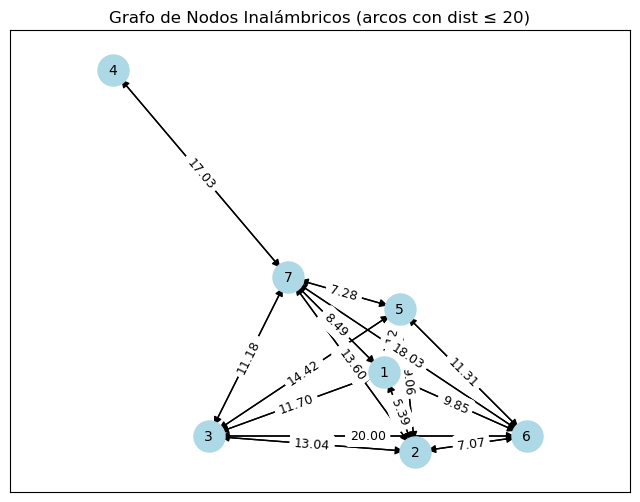

In [65]:
G = nx.DiGraph()

for (i, j) in cost:
    G.add_edge(i, j, weight=cost[(i, j)])

pos = {n: coords[n] for n in coords}  

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=12)

edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {(i,j): f"{edge_labels[(i,j)]:.2f}" for (i,j) in edge_labels}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Grafo de Nodos Inalámbricos (arcos con dist ≤ 20)")
plt.axis('equal') 
plt.show()


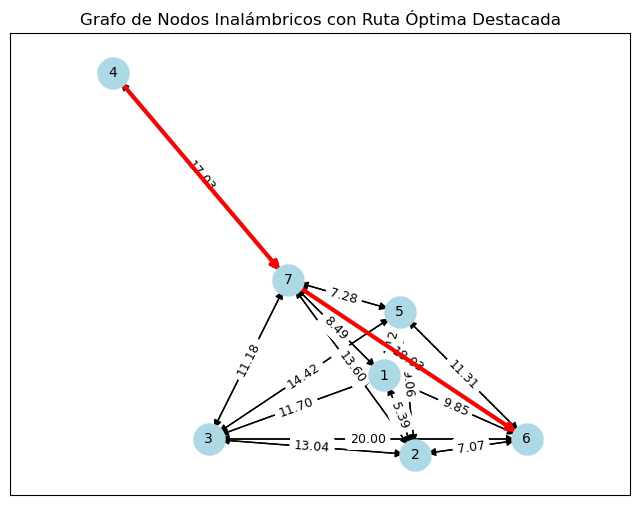

In [ ]:
used_arcs = [(4, 7), (7, 6)]
G = nx.DiGraph()

for (i, j) in cost:
    G.add_edge(i, j, weight=cost[(i, j)])

pos = {n: coords[n] for n in coords}  

plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=12)

edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {(i,j): f"{edge_labels[(i,j)]:.2f}" for (i,j) in edge_labels}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=used_arcs,     
    arrows=True,
    arrowstyle='-|>',
    arrowsize=12,
    edge_color='red',     
    width=3    
)
plt.title("Grafo de Nodos Inalámbricos con Ruta Óptima Destacada")
plt.axis('equal')
plt.show()

### Conclusiones

El modelo en Pyomo confirma que la **ruta de menor costo** entre los nodos 4 y 6, para esta red de 7 nodos móviles inalámbricos, tiene un costo total de aproximadamente **35.06** y se construye mediante los arcos $\{(4,7), (7,6)\}$, conformando la ruta $[4, 7, 6]$. La formulación basada en el modelo de flujo unitario (con variables binarias para cada enlace posible) y la correspondiente restricción de balance de flujo se mostró efectiva, permitiendo que el solver GLPK encontrara una solución factible y óptima de forma clara. La **matriz de costos** empleada (distancias $\le 20$) y las coordenadas proporcionadas ilustran la importancia de un adecuado **preprocesamiento**: solo se consideran aquellos enlaces con distancia menor o igual a 20, lo que limita el tamaño del problema y garantiza la consistencia de la red. Este enfoque es escalable a redes más grandes o variantes del problema (por ejemplo, restricciones adicionales de capacidad o enlaces dirigidos), lo que lo hace ampliamente aplicable en contextos de *rutas óptimas* y *planificación de redes*.